In [17]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import feature_extraction as FE
import classifier as CL
from skimage.feature import hog
import skimage as ski
import matplotlib.pyplot as pt
import torch
import torchvision as TV
import PIL.Image as Image
import pathlib as pb
import pandas as ps
import numpy as ny
import torch as to
import torch.nn as nn
import typing
import random as rnd
import os as so
import cv2

In [19]:
# Configure the paths to the required files
ROOT_PATH = pb.Path('..')
DATA_PATH = ROOT_PATH / 'copy'
IMAGES_PATH = DATA_PATH / 'images'
TEST_LABELS_PATH = DATA_PATH / 'test.csv'
TRAIN_LABELS_PATH = DATA_PATH / 'train.csv'
OUTPUT_DIR = ROOT_PATH / 'output'

# Use accelerated computing option if available on the current running machine
CURRENT_DEVICE = to.device('cuda' if to.cuda.is_available() else 'cpu')
RUNTIME_SEED = 98
RAND_GENERATOR = ny.random.default_rng(RUNTIME_SEED)

# Try to redo the results and get the expected values
ny.random.seed(RUNTIME_SEED)
torch.manual_seed(RUNTIME_SEED)
rnd.seed(RUNTIME_SEED)

In [20]:
# Read metadata from disk
train_set = ps.read_csv(TRAIN_LABELS_PATH, sep=',', header=0, names=['image', 'label'], dtype={'image': str, 'label': ny.int64})
test_set = ps.read_csv(TEST_LABELS_PATH, sep=',', header=0, names=['image'], dtype=str)

In [21]:
# Make sure all files are present on disk
image_filenames = [image_file.name for image_file in IMAGES_PATH.glob('*.jpg')]
assert train_set['image'].isin(image_filenames).all(), 'Missing train images.'
assert test_set['image'].isin(image_filenames).all(), 'Missing test images.'

# Make sure no train files are in test or vice versa
assert not train_set['image'].isin(test_set['image']).any(), 'Found leaked files.'

# Make sure there are no duplicated files
assert len(train_set['image'].unique()) == len(train_set['image']), 'Duplicated files in train.'
assert len(test_set['image'].unique()) == len(test_set['image']), 'Duplicated files in test.'

# Make sure labels are 6 classes
assert len(train_set['label'].unique()) == 6, 'Wrong number of classes.'
assert train_set['label'].isin(list(range(6))).all(), 'Bad labels were found.'

In [22]:
# Extract some stats to use later
n_class = len(train_set['label'].unique())

# Name the given classes
class_names = [
  'glacier',
  'buildings',
  'sea',
  'forests',
  'street',
  'mountains',
]

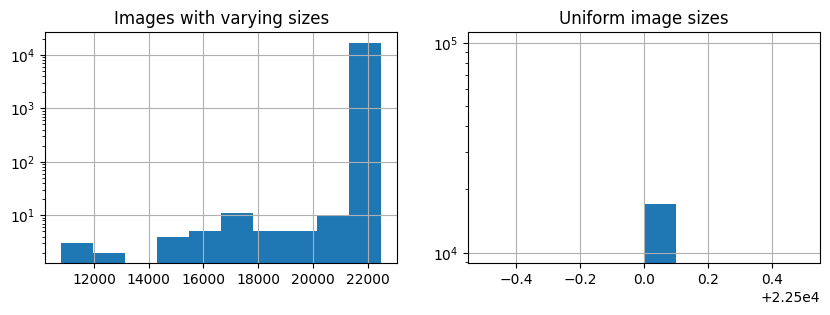

In [23]:
# Find images that have different sizes than 150x150x3
image_sizes = []
mark_for_delete = []
for index, row in train_set.iterrows():
  image_filepath: str = str(IMAGES_PATH / row['image'])
  image_info = Image.open(image_filepath, mode='r')
  assert image_info.mode == 'RGB', 'Image must have three channels.'
  image_sizes.append(image_info.width * image_info.height)
  if image_info.height != 150 or image_info.width != 150:
    mark_for_delete.append(index)

# Show how many images deviate from the expectation
f, (pre_removal_axis, post_removal_axis) = pt.subplots(1, 2, figsize=(10, 3))

# Inspect the current deviations
pre_removal_axis.grid(True)
pre_removal_axis.set_yscale('log')
pre_removal_axis.hist(image_sizes)
pre_removal_axis.set_title('Images with varying sizes')

# As the number of images that deviate is small, remove them from further experiments
train_rset: ps.DataFrame = train_set          \
  .drop(labels=mark_for_delete, axis='index') \
  .reset_index(drop=True)
train_set = train_rset

# Inspect teh result
post_removal_axis.grid(True)
post_removal_axis.set_yscale('log')
post_removal_axis.hist([sz for i, sz in enumerate(image_sizes) if i not in mark_for_delete])
post_removal_axis.set_title('Uniform image sizes')
pt.show()

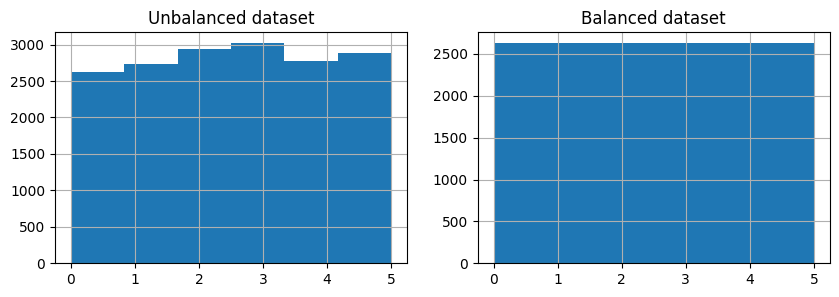

In [24]:
# Investigate class imbalance
f, (pre_balance_axis, post_balance_axis) = pt.subplots(1, 2, figsize=(10, 3))

# Before balancing the dataset
train_set['label'].hist(ax=pre_balance_axis, bins=n_class)
pre_balance_axis.set_title('Unbalanced dataset')

# Obtain the minimum amount of intra-class entries
min_class_count: int = train_set \
  .groupby('label')              \
  .count()                       \
  .min()                         \
  .item()

# Keep first min_entries for each class
train_bset: ps.DataFrame = train_set                  \
  .groupby('label', as_index=False, sort=False)       \
  .apply(lambda labels: labels.head(min_class_count)) \
  .reset_index(drop=True)

# Resort the data by image number
i_sort_by_name: ps.Index | ps.MultiIndex = train_bset['image'] \
  .apply(lambda image: int(image.split('.jpg')[0]))            \
  .sort_values()                                               \
  .index
train_bset: ps.DataFrame = train_bset.iloc[i_sort_by_name, :] \
  .reset_index(drop=True)

# Update current state
train_set = train_bset

# After balancing the data
train_bset['label'].hist(ax=post_balance_axis, bins=n_class)
post_balance_axis.set_title('Balanced dataset')
pt.show()

In [25]:
# Read each image as RGB (150x150x3)
train_data= []
for index, row in train_set.iterrows():
  image_filepath: str = str(IMAGES_PATH / row['image'])
  image = cv2.imread(image_filepath, flags=cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  train_data.append(image)

# Stack images along a new axis
train_data = ny.stack(train_data, axis=0).transpose((0, 3, 1, 2))
train_labels = ny.array(train_set['label'], dtype=ny.int64)

In [26]:
# Split training data into train-test
train_factor = 0.8
train_pivot:int = ny.floor(train_factor * len(train_data)).astype(ny.int32).item()

# Perform shuffling before distributing the samples
shuffled_indices = RAND_GENERATOR.permutation(len(train_data))
i_train = shuffled_indices[:train_pivot]
i_test = shuffled_indices[train_pivot:]

# Distribute samples accordingly
test_data = train_data[i_test]
test_labels = train_labels[i_test]
train_data = train_data[i_train]
train_labels = train_labels[i_train]

# Select random image for visualization purposes
image_index = RAND_GENERATOR.integers(0, len(train_data))
image: ny.ndarray = train_data[image_index]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


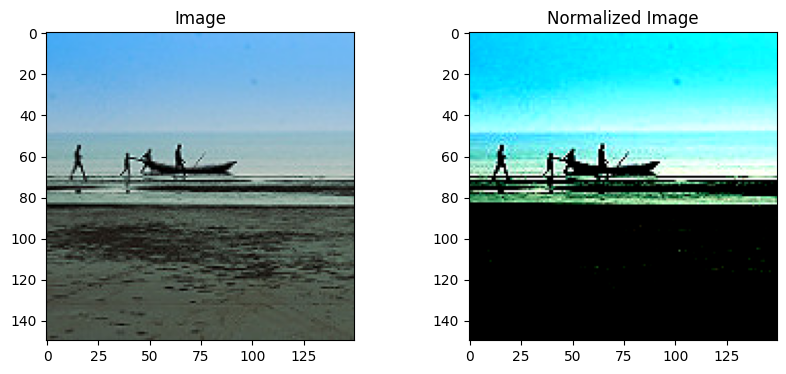

In [27]:
# Use image per-channel normalization on the data
norm_extractor: FE.FeatureExtractor = FE.ImageFeatureExtractor(grayscale=False)
norm_extractor.fit_transform(train_data)
norm_image = norm_extractor.transform_image(image).reshape(-1, *image.shape[1:]).transpose((1, 2, 0))

# Visualize the result
f, (img_axis, key_axis) = pt.subplots(nrows=1, ncols=2, figsize=(10, 4))
img_axis.imshow(image.transpose((1, 2, 0)))
img_axis.set_title('Image')
key_axis.imshow(norm_image, vmin=norm_image.min(), vmax=norm_image.max())
key_axis.set_title('Normalized Image')
pt.show()

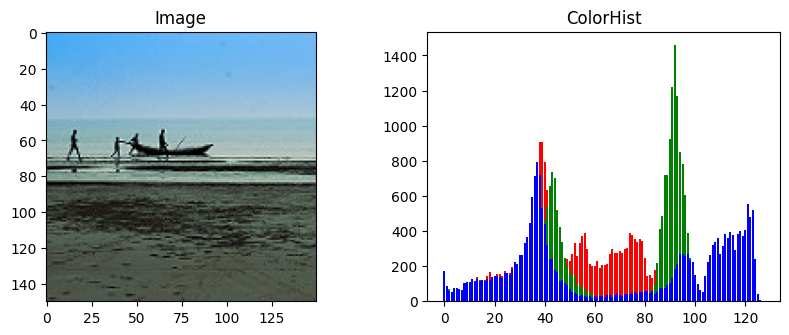

In [28]:
# Showcase colorhist outputs
colorhist_extractor: FE.FeatureExtractor = FE.ColorHistFeatureExtractor(density=False, intervals=128)
colorhist_extractor.fit_transform(train_data)

image_features = colorhist_extractor.transform_image(image)
r_hist, g_hist, b_hist = ny.split(image_features, 3)

# Display the image to confirm the results
f, (img_axis, hist_axis) = pt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
img_axis.imshow(image.transpose((1, 2, 0)))
img_axis.set_title('Image')

# Highlight the histograms
x_axis_indices = ny.arange(r_hist.shape[0])
hist_axis.bar(x_axis_indices, r_hist, color='red')
hist_axis.bar(x_axis_indices, g_hist, color='green')
hist_axis.bar(x_axis_indices, b_hist, color='blue')
hist_axis.set_title('ColorHist')
pt.show()

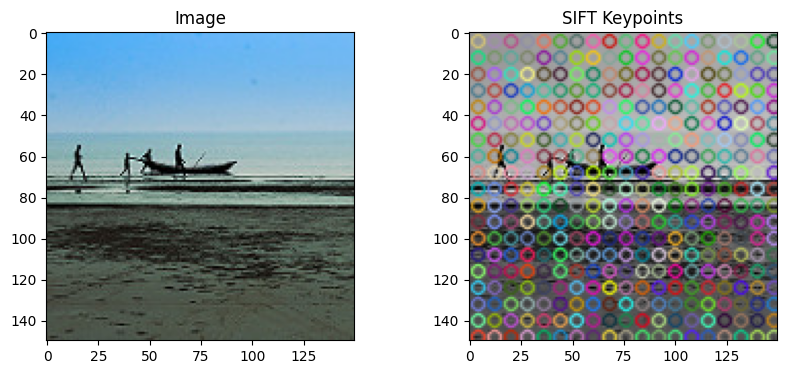

In [29]:
# Use SIFT to retrieve important descriptors of the image
sift_transformer: FE.FeatureTransformer = FE.SIFTFeatureTransformer(visualize=True)
kpts, desc, gray_image, raw_img = sift_transformer.transform(image)
vizun_image = cv2.drawKeypoints(gray_image, kpts, ny.empty_like(gray_image))
sift_transformer._visualize = False

# Visualize the result
f, (img_axis, key_axis) = pt.subplots(nrows=1, ncols=2, figsize=(10, 4))
img_axis.imshow(image.transpose((1, 2, 0)))
img_axis.set_title('Image')
key_axis.imshow(vizun_image)
key_axis.set_title('SIFT Keypoints')
pt.show()

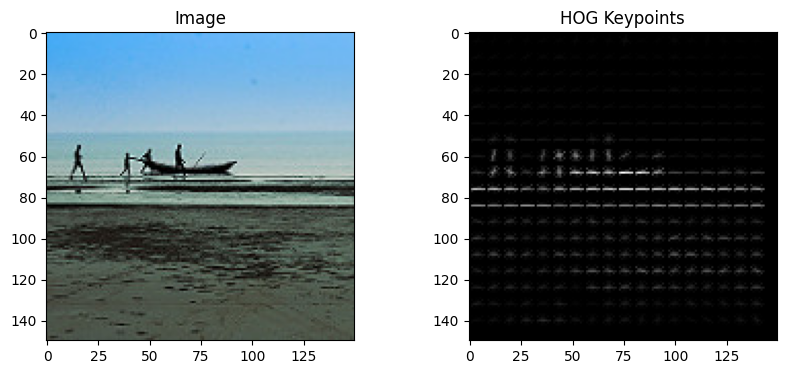

In [30]:
# Use HOG to retrieve important descriptors of the image
hog_transformer: FE.FeatureTransformer = FE.HOGFeatureTransformer(visualize=True, grayscale=False)
desc, vizun_image = hog_transformer.transform(image)
hog_transformer._visualize = False

# Visualize the result
f, (img_axis, key_axis) = pt.subplots(nrows=1, ncols=2, figsize=(10, 4))
img_axis.imshow(image.transpose((1, 2, 0)))
img_axis.set_title('Image')
key_axis.imshow(vizun_image, cmap='gray')
key_axis.set_title('HOG Keypoints')
pt.show()

In [34]:
# Shuffle the training data and do a train-valid split for all gridsearch runs
train_valid_split = 0.8
train_valid_pivot = ny.floor(train_valid_split * len(train_data)).astype(ny.int32).item()
i_rand = RAND_GENERATOR.permutation(len(train_data))
i_train_split = i_rand[:train_valid_pivot]
i_valid_split = i_rand[train_valid_pivot:]
grid_indices = [(i_train_split, i_valid_split)]

In [42]:
# FeatureExtractor search space
feature_extractors = [
  # FE.BOVWFeatureExtractor(n_features=10, batch_size=2048, transformer=FE.SIFTFeatureTransformer()),
  # FE.BOVWFeatureExtractor(n_features=128, batch_size=2048, transformer=FE.SIFTFeatureTransformer()),
  # FE.BOVWFeatureExtractor(n_features=512, batch_size=2048, transformer=FE.SIFTFeatureTransformer()),
  FE.BOVWFeatureExtractor(n_features=512, transformer=FE.HOGFeatureTransformer()),
  FE.ImageFeatureExtractor(grayscale=False, min_max=True),
  CL.TransferLearningClassifier(n_classes=n_class, device=CURRENT_DEVICE, batch_size=128),
  FE.ColorHistFeatureExtractor(intervals=256),
  FE.ColorHistFeatureExtractor(intervals=128),
  FE.ColorHistFeatureExtractor(intervals=64),
  FE.BOVWFeatureExtractor(n_features=128, batch_size=2048, transformer=FE.HOGFeatureTransformer(grayscale=False)),
  FE.BOVWFeatureExtractor(n_features=512, batch_size=2048, transformer=FE.HOGFeatureTransformer(grayscale=False)),
]

# HyperParameter search space
affinity_params = {
  'damping': [0.5, 0.75, 0.99],
}
dbscan_params = {
  'eps': [0.1, 0.15, 0.25, 0.5, 0.75],
  'min_samples': [5, 7, 15, 20],
  'p': [1, 2],
}

# List the currently implemented classifier
dbscan_classifier = CL.DBSCANClassifier()
affinity_classifier = CL.AffinityPropagationClassifier()

# Chosen implementation
alg_classifier = {
  'model': dbscan_classifier,
  'params': dbscan_params,
  'name': 'dbscan'
}

In [43]:
# Define search procedure in order to automatically find the best params
search = GridSearchCV(
  estimator=alg_classifier['model'],
  param_grid={
    'f_extractor': feature_extractors,
    'silhouette_dist': ['l2'],
    **alg_classifier['params'],
  },
  verbose=4,
  refit=False,
  cv=grid_indices,
)

# Start search
search.fit(train_data, train_labels)

Fitting 1 folds for each of 320 candidates, totalling 320 fits
[CV 1/1] END eps=0.1, f_extractor=FE_BOVW_T_HOG, min_samples=5, p=1, silhouette_dist=l2; accuracy: (test=0.176) silhouette: (test=-1.000) total time= 1.9min
[CV 1/1] END eps=0.1, f_extractor=FE_BOVW_T_HOG, min_samples=5, p=2, silhouette_dist=l2; accuracy: (test=0.176) silhouette: (test=-1.000) total time= 2.1min


KeyboardInterrupt: 

In [ ]:
# Save results to present later
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
results = ps.DataFrame(search.cv_results_)
results.to_csv(OUTPUT_DIR / f'{alg_classifier["name"]}_grid_search.csv')
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_damping,param_f_extractor,param_silhouette_dist,params,split0_test_silhouette,mean_test_silhouette,std_test_silhouette,rank_test_silhouette,split0_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,143.907790,0.0,10.412176,0.0,0.5,FE_BOVW_T_HOG,l2,"{'damping': 0.5, 'f_extractor': FE_BOVW_T_HOG,...",0.076961,0.076961,0.0,1,0.581681,0.581681,0.0,10
1,165.831330,0.0,10.439767,0.0,0.5,FE_BOVW_T_HOG,l2,"{'damping': 0.5, 'f_extractor': FE_BOVW_T_HOG,...",-0.023555,-0.023555,0.0,10,0.657415,0.657415,0.0,4
2,155.539944,0.0,10.686280,0.0,0.5,FE_BOVW_T_HOG,l2,"{'damping': 0.5, 'f_extractor': FE_BOVW_T_HOG,...",-0.030062,-0.030062,0.0,18,0.628073,0.628073,0.0,7
3,55.903265,0.0,2.333208,0.0,0.5,FE_TL,l2,"{'damping': 0.5, 'f_extractor': FE_TL, 'silhou...",-0.031614,-0.031614,0.0,20,0.877478,0.877478,0.0,1
4,42.953222,0.0,1.885937,0.0,0.5,FE_ImgNorm,l2,"{'damping': 0.5, 'f_extractor': FE_ImgNorm, 's...",-0.022930,-0.022930,0.0,4,0.462331,0.462331,0.0,22


In [41]:
# Final run using DBSCAN
clustering = CL.DBSCANClassifier(
  p=2,
  eps=0.1,
  min_samples=5,
  f_extractor=FE.BOVWFeatureExtractor(
    n_features=512,
    transformer=FE.HOGFeatureTransformer()
  )
)

clustering.fit(train_data)
clustering.score(test_data, test_labels)

{'silhouette': -0.07517057250598053, 'accuracy': 0.24389470345702505}

In [38]:
# Final run using AffinityPropagation
clustering = CL.AffinityPropagationClassifier(
  damping=0.5,
  f_extractor=CL.TransferLearningClassifier(n_class, CURRENT_DEVICE)
)

clustering.fit(train_data)
clustering.score(test_data, test_labels)

{'silhouette': -0.02706918, 'accuracy': 0.8845543926419284}

In [39]:
# Evaluate supervised approach
tl_classifier: CL.Classifier = CL.TransferLearningClassifier(epochs=20,
                                                             batch_size=64,
                                                             n_classes=n_class,
                                                             device=CURRENT_DEVICE,
                                                             verbose=True)

# Finetune on the train split for couple of epochs
tl_classifier.fit(train_data, train_labels)

# Determine the supervised baseline
test_labels_pred = tl_classifier.predict(test_data)

# Compute the metrics
accuracy = metrics.accuracy_score(test_labels, test_labels_pred)

# Display the baseline
print(f'Supervised Accuracy: {accuracy}')

epoch: 0 - accuracy: 0.89
epoch: 1 - accuracy: 0.91
epoch: 2 - accuracy: 0.93
epoch: 3 - accuracy: 0.93
epoch: 4 - accuracy: 0.94
epoch: 5 - accuracy: 0.94
epoch: 6 - accuracy: 0.94
epoch: 7 - accuracy: 0.95
epoch: 8 - accuracy: 0.95
epoch: 9 - accuracy: 0.95
epoch: 10 - accuracy: 0.96
epoch: 11 - accuracy: 0.95
epoch: 12 - accuracy: 0.96
epoch: 13 - accuracy: 0.96
epoch: 14 - accuracy: 0.96
epoch: 15 - accuracy: 0.96
epoch: 16 - accuracy: 0.97
epoch: 17 - accuracy: 0.97
epoch: 18 - accuracy: 0.97
epoch: 19 - accuracy: 0.97
Supervised Accuracy: 0.9400570884871551


In [40]:
print(f'Random Chance Accuracy: {1. / n_class}')

Random Chance Accuracy: 0.16666666666666666
